In [7]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import isspmatrix_csc, isspmatrix_csr
from joblib import Memory
import numpy as np


DIR = "./datasets/"

# Dataset source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w1a
W1A = DIR + "w1a"
W1A_FEATURES = 300

# Cache the read datasets so they are loaded faster
# on subsequent program runs
mem = Memory("./cache")

@mem.cache
def get_data(filepath, n_features, dtype):
    data = load_svmlight_file(filepath, n_features, dtype)
    return data[0], data[1]

X, y = get_data(W1A, W1A_FEATURES, np.int32)

In [8]:
# Recursive adaptive coordinate descent method
# Yu. Nesterov - Efficiency of coordinate descent methods on huge-scale optimization problems
from random import randint
import numpy as np

EPSILON = 0.000001


# p = number of features = number of coordinates
# x0 - initial values for the loss function weights, size (p, 1)
# the loss func's gradient - a vector of partial derivatives, size (p, 1), that take xk as a parameter
# iter number of iterations
def racdm(x0, gradient, iter):
    p, _ = x0.shape
    # generate initial non-zero vector of Lipschitz constants
    L = 1 / (np.random.rand(p, 1) + EPSILON)

    xprev = x0

    for k in range(iter):
        ik = randint(0, p - 1)

        dfprev = gradient(xprev)[ik]

        xnext = np.copy(xprev)
        xnext[ik] -= ((1 / L[ik]) * dfprev)

        dfnext = gradient(xnext)[ik]

        # if the learning rate is too large, it will change the derivative's sign
        while dfprev * dfnext < 0:
            L[ik] = 2 * L[ik]

            xnext = np.copy(xprev)
            xnext[ik] -= ((1 / L[ik]) * dfprev)

            dfnext = gradient(xnext)[ik]

        xprev = xnext
        L[ik] = (1 / 2) * L[ik]

    return xnext, L

In [9]:
from functools import partial

# X (n, p) 
# y (n)
# beta (p, 1) the weights of the logistic loss
def logloss_gradient(X, y, beta):
    # n number of samples
    # p number of features
    n, p = X.shape
    w = np.ones((n, 1))

    # yi = i-th sample's label
    # xi = i-th sample -> (1, p)
    for i in range(n):
        exp = np.exp(-y[i] * X[i].dot(beta))

        w[i] = -y[i] * (exp / (1 + exp))

    return (1 / n) * X.transpose().dot(w)


def logloss(X, y, beta):
    n, p = X.shape
    sum = 0

    for i in range(n):
        sum += np.log(1 + np.exp(-y[i] * X[i].dot(beta)))

    return (1 / n) * sum

n, p = X.shape
# initial weight of the loss function
beta = np.zeros((p, 1))

partial_derivative = partial(logloss_gradient, X, y)

# beta_opt, L = racdm(beta, partial_derivative, 10000)

# print(beta_opt)
# print(L)

In [33]:
from random import randint

# Accelerated coordinate descent framework for the miu strongly convex case
# x0 - initial values for the loss function weights, size (n, 1)
# iter number of iterations
# gradient the function that computes the full gradient for a parameter gradient(beta)
# coord1 and coord2 are functions that take in (L, full_gradient) as params and return the chosen coords
def miu_strong_acc_cd(x0, miu, iter, gradient, coord1, coord2, report_progress):
    n, _ = x0.shape

    a = np.sqrt(miu) / (n + np.sqrt(miu))
    b = (miu * a) / (n * n)

    # generate initial non-zero vector of Lipschitz constants
    L = 1 / (np.random.rand(p, 1) + EPSILON)

    # z0 = x0
    zprev = x0
    xprev = x0

    for k in range(iter + 1):
        if k % 100 == 0:
            report_progress(k, iter, xprev)

        yk = (1 - a) * xprev + a * zprev
        full_grad = gradient(yk)

        jk1 = coord1(L, full_grad)
        ejk1 = np.zeros((n, 1))
        ejk1[jk1] = 1

        xnext = yk - (1 / L[jk1]) * full_grad[jk1] * ejk1
        uprev = ((a * a) / (a * a + b)) * zprev + (b / (a * a + b)) * yk

        # reuse allocated ejk1
        ejk2 = ejk1

        # don't compute the argmin again for agcd
        if coord1 is coord2 and coord1 is greedy_choice:
            jk2 = jk1
        else:
            jk2 = coord2(L, full_grad)
            ejk2[jk1] = 0
            ejk2[jk2] = 1

        znext = uprev - (a / (a * a + b)) * (1 / (n * L[jk2])) * full_grad[jk2] * ejk2

        zprev = znext
        xprev = xnext

    return xnext


# rules functions used by the accelerated coord descent fw above:

# choose a coordinate uniformly for the randomized cd / semi-greedy cd
def uniform_choice(L, full_gradient):
    n, _ = L.shape

    return randint(0, n - 1)


def greedy_choice(L, full_gradient):
    gsl = (1 / np.sqrt(L)) * np.abs(full_gradient)

    return np.argmax(gsl)

iterations: 0 / 10000
iterations: 100 / 10000
iterations: 200 / 10000
iterations: 300 / 10000
iterations: 400 / 10000
iterations: 500 / 10000
iterations: 600 / 10000
iterations: 700 / 10000
iterations: 800 / 10000
iterations: 900 / 10000
iterations: 1000 / 10000
iterations: 1100 / 10000
iterations: 1200 / 10000
iterations: 1300 / 10000
iterations: 1400 / 10000
iterations: 1500 / 10000
iterations: 1600 / 10000
iterations: 1700 / 10000
iterations: 1800 / 10000
iterations: 1900 / 10000
iterations: 2000 / 10000
iterations: 2100 / 10000
iterations: 2200 / 10000
iterations: 2300 / 10000
iterations: 2400 / 10000
iterations: 2500 / 10000
iterations: 2600 / 10000
iterations: 2700 / 10000
iterations: 2800 / 10000
iterations: 2900 / 10000
iterations: 3000 / 10000
iterations: 3100 / 10000
iterations: 3200 / 10000
iterations: 3300 / 10000
iterations: 3400 / 10000
iterations: 3500 / 10000
iterations: 3600 / 10000
iterations: 3700 / 10000
iterations: 3800 / 10000
iterations: 3900 / 10000
iterations: 

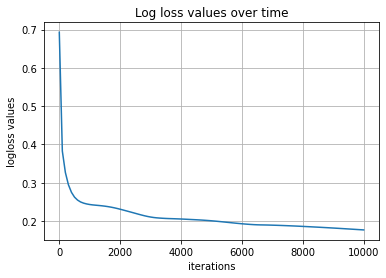

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def run_logloss_acgd(iters):
    logloss_values = np.zeros(int(iters / 100 + 1))

    def report_progress(curr_iter, iters, curr_beta):
        print('iterations: %d / %d' % (curr_iter, iters))

        logloss_values[int(curr_iter / 100)] = logloss(X, y, curr_beta)

    beta_opt = miu_strong_acc_cd(beta, 1e-7, iters, partial_derivative, greedy_choice, greedy_choice, report_progress)

    print(beta_opt)

    # Data for plotting
    xs = np.arange(0, iters + 1, 100)
    ys = logloss_values

    fig, ax = plt.subplots()
    ax.plot(xs, ys)

    ax.set(xlabel='iterations', ylabel='logloss values',
        title='Log loss values over time')
    ax.grid()

    fig.savefig("logloss.png")
    plt.show()


run_logloss_acgd(10000)